# Module 14: Weight Initialization

**Starting Strong**

---

## Objectives

By the end of this notebook, you will:
- Understand why initialization matters
- Master Xavier and He initialization
- Know when to use which method
- Apply custom initialization in PyTorch

---

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)

---

# Part 1: Why Initialization Matters

---

Bad initialization can cause:
- **Vanishing gradients**: Weights too small, gradients shrink to zero
- **Exploding gradients**: Weights too large, gradients grow unbounded

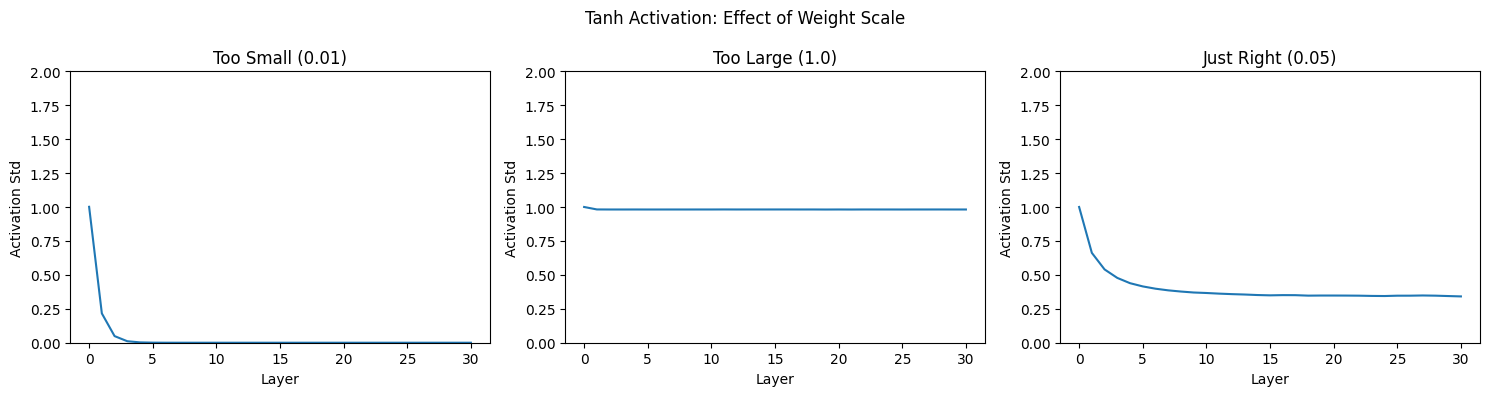

In [2]:
# Demonstrate the problem
def forward_pass(n_layers, w_scale, activation='tanh'):
    """Simulate forward pass through n layers."""
    x = torch.randn(1000, 512)
    activations = [x.std().item()]

    for _ in range(n_layers):
        W = torch.randn(512, 512) * w_scale
        x = x @ W
        if activation == 'tanh':
            x = torch.tanh(x)
        elif activation == 'relu':
            x = torch.relu(x)
        activations.append(x.std().item())

    return activations

# Test different weight scales
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, scale, title in zip(axes, [0.01, 1.0, 0.05], ['Too Small (0.01)', 'Too Large (1.0)', 'Just Right (0.05)']):
    acts = forward_pass(30, scale)
    ax.plot(acts)
    ax.set_xlabel('Layer')
    ax.set_ylabel('Activation Std')
    ax.set_title(title)
    ax.set_ylim(0, 2)

plt.suptitle('Tanh Activation: Effect of Weight Scale', fontsize=12)
plt.tight_layout()
plt.show()

---

# Part 2: Xavier/Glorot Initialization

---

For tanh/sigmoid activations:

$$W \sim \mathcal{U}\left(-\sqrt{\frac{6}{n_{in} + n_{out}}}, \sqrt{\frac{6}{n_{in} + n_{out}}}\right)$$

Or normal distribution:
$$W \sim \mathcal{N}\left(0, \frac{2}{n_{in} + n_{out}}\right)$$

In [3]:
# Xavier initialization
layer = nn.Linear(512, 256)

# Uniform
nn.init.xavier_uniform_(layer.weight)
print(f"Xavier Uniform - Std: {layer.weight.std().item():.4f}")

# Normal
nn.init.xavier_normal_(layer.weight)
print(f"Xavier Normal - Std: {layer.weight.std().item():.4f}")

Xavier Uniform - Std: 0.0510
Xavier Normal - Std: 0.0510


---

# Part 3: He/Kaiming Initialization

---

For ReLU activations (accounts for zero half):

$$W \sim \mathcal{N}\left(0, \frac{2}{n_{in}}\right)$$

In [4]:
# He initialization
layer = nn.Linear(512, 256)

# For ReLU
nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
print(f"He Normal (ReLU) - Std: {layer.weight.std().item():.4f}")

# For Leaky ReLU
nn.init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='leaky_relu')
print(f"He Normal (LeakyReLU) - Std: {layer.weight.std().item():.4f}")

He Normal (ReLU) - Std: 0.0624
He Normal (LeakyReLU) - Std: 0.0626


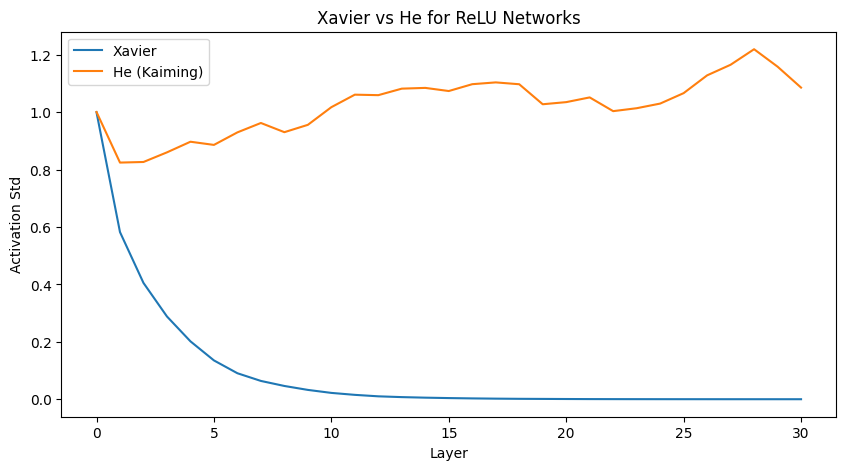

In [5]:
# Compare Xavier vs He for ReLU
def test_init(init_fn, n_layers=30):
    x = torch.randn(1000, 512)
    stds = [x.std().item()]

    for _ in range(n_layers):
        layer = nn.Linear(512, 512, bias=False)
        init_fn(layer.weight)
        x = torch.relu(layer(x))
        stds.append(x.std().item())

    return stds

fig, ax = plt.subplots(figsize=(10, 5))

stds_xavier = test_init(nn.init.xavier_normal_)
stds_he = test_init(lambda w: nn.init.kaiming_normal_(w, nonlinearity='relu'))

ax.plot(stds_xavier, label='Xavier')
ax.plot(stds_he, label='He (Kaiming)')
ax.set_xlabel('Layer')
ax.set_ylabel('Activation Std')
ax.set_title('Xavier vs He for ReLU Networks')
ax.legend()
plt.show()

---

# Part 4: Applying Custom Initialization

---

In [6]:
# Initialize entire network
def init_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
        if module.bias is not None:
            nn.init.zeros_(module.bias)

model = nn.Sequential(
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

# Apply initialization
model.apply(init_weights)

print("Initialized network weights:")
for name, param in model.named_parameters():
    if 'weight' in name:
        print(f"  {name}: std={param.std().item():.4f}")

Initialized network weights:
  0.weight: std=0.0504
  2.weight: std=0.0884
  4.weight: std=0.1243


---

# Quick Reference

| Activation | Initialization |
|------------|----------------|
| Tanh/Sigmoid | Xavier (Glorot) |
| ReLU | He (Kaiming) |
| Leaky ReLU | He with `nonlinearity='leaky_relu'` |
| Linear (output) | Xavier or small random |

---

## Next Module: [15 - Batch Normalization](../15_batch_norm/15_batch_norm.ipynb)